# Machine Learning Explainability Template
**Visualize and explain predictions of any regression models with histograms, feature importances, ELI5 and SHAP**

---

This is a template that you can use to explain your supervised regression machine learning models. Please read the instruction in the README.md to run this template. After uploading a trained model and the dataset to this template or training the model, template outputs the plots generated with: 

* Histogram of true target values and predicted target values
* Feature importances
* Permutation importances with ELI5
* Individual prediction explanations with SHAP 

## Introduction
---

Machine learning (ML) models are no more *black-box* applications that just produces the predictions. There are some great open-source frameworks and plots that can be used to visualize results of any ML model. 

**Why machine learning explainability is important?**

Data scientist are the point of contacts between the ML applications and the users of these applications. With the wide-use of ML everywhere in our daily lives, explaining **whats** and **whys** of the models is as important as building the model itself for a data scientist. Understandability of the ML models will widen the use of ML applications even more.

As a data scientist, you will be expected to discuss the outcomes of the ML application with the stakeholders who are likely to have limited knowledge of ML. By using explanatory frameworks and charts, you can easily communicate with a non-technical audience. These frameworks and charts will assist you in solidifying the outputs of the ML solution and tailoring the message according to the audience.

## Information About the Dataset
---

[California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing) will be used in this template. Dataset consists of 8 features:

* **MedInc:** Median Income in the block
* **HouseAge:** House age
* **AveRooms:** Average number of rooms
* **AveBedrms:** Average number of bedrooms
* **Population:** Block population
* **AveOccup:** Average house occupancy
* **Latitude:** House block latitude
* **Longitude:** House block longitude

and a target value, **MedHouseVal** which shows values of houses in 100,000 dollars.  and ranging between 

Target is ranging between 0.15 - 5.0 where the cheapest home 15,000$ and the most expensive home is 500,000$ Having continuous integers as target variable makes this problem a **regression** problem.

Moreover, this is **supervised machine learning problem** because both the features and the target is presented in the dataset.

To illustrate the machine learning explainability, a random forest regressor with the default hyperparameters will be trained. 

To get started, let's import the necessary libraries and define the helper functions to use in this template:

## Imports
---

In [1]:
# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# data manipulation libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

# data 
from sklearn.datasets import fetch_california_housing

# machine learning training libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# machine learning explainability
import shap
import eli5
from eli5.sklearn import PermutationImportance

# to bypass warnings in section regarding previous imports
import warnings
warnings.filterwarnings('ignore')

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


## Helper functions
---

In [2]:
# model training and array conversion functions
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return mean_squared_error(y_valid, y_predicted)

def convert_features_to_array(features):
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np
                      .array(features)
                      .reshape((num_rows, 
                                num_cols)))

    return features_array

def convert_target_to_array(target):
    target_array = np.array(target).reshape((-1, ))
    return target_array



In [3]:
# plotting functions
def PlotPredictedVSActual(predictions, actuals):
    figsize(20, 10)
    plt.rcParams['font.size'] = 14

    # histogram of predictions
    ax = plt.subplot(121)
    ax.hist(predictions,
            bins=20, 
            color = "#4169E1", 
            edgecolor = 'white')
    ax.set_xlabel("target", size=14)
    ax.set_xticks(range(0, 5))
    ax.set_ylabel("count", size=14)
    ax.set_title("Predicted Distribution", size=16)
    plt.grid(b=True, axis = 'y', alpha=0.3)

    # histogram of actual values
    ax2 = plt.subplot(122)
    ax2.hist(actuals,
             bins=20, 
             color = "#4169E1", 
             edgecolor = 'white')
    ax2.set_xlabel("target", size=14)
    ax2.set_xticks(range(0, 5))
    ax2.set_ylabel("count", size=14)
    ax2.set_title("Actual Distribution", size=16)
    plt.grid(b=True, axis = 'y', alpha=0.3)
    
def PlotFeatureImportances(model, feature_names):
    feature_importances = (pd
                           .DataFrame(
                               {'feature': feature_names,
                                'importance': model
                                .feature_importances_}))

    feature_importances = (feature_importances
                           .sort_values(by="importance",
                                        ascending=False))
    figsize(20, 10)
    plt.rcParams['font.size'] = 20
    sns.set(font_scale=1.5, style="whitegrid")

    # set color
    labels = np.array(feature_importances.feature)
    values = np.array(feature_importances.importance) 
    colors = ["#808080" if (y < max(values))
              else "#4169E1" for y in values]

    # set the plot
    ax = sns.barplot(x="importance", 
                     y="feature", 
                     data=feature_importances, 
                     palette = colors)

    # set title and save plot
    plt.title("Feature Importances", size = 20)

## Load Data
---

In [4]:
df = fetch_california_housing(as_frame=True)

In [5]:
df.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
df.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

All features are numeric. Moreover, features are separated from the target. 

Since we don't have a distinct test dataset for this case, 25% of the dataset will be held-out as the test dataset. This will also enable comparing the distributions of the true and predicted values of the target in histograms.

## Training the Model
---


In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df.data, 
    df.target, 
    test_size=0.25, 
    random_state=42)

In [8]:
# build the model, look at the mean square error
random_forest_model = RandomForestRegressor(random_state=42)

print("The mean square error of the model is {}"
      .format(
          round(
              fit_evaluate_model(random_forest_model, 
                                 X_train, 
                                 y_train, 
                                 X_test, 
                                 y_test),2)))

The mean square error of the model is 0.25


Let's generate the predcitions with `random_forest_model` and save them into the `predictions`.

In [9]:
# train model and generate predictions
random_forest_model.fit(X_train, y_train)

predictions = (random_forest_model.predict(X_test))

## Explain Model Predictions
---



### Histograms to compare to actual and predcited values

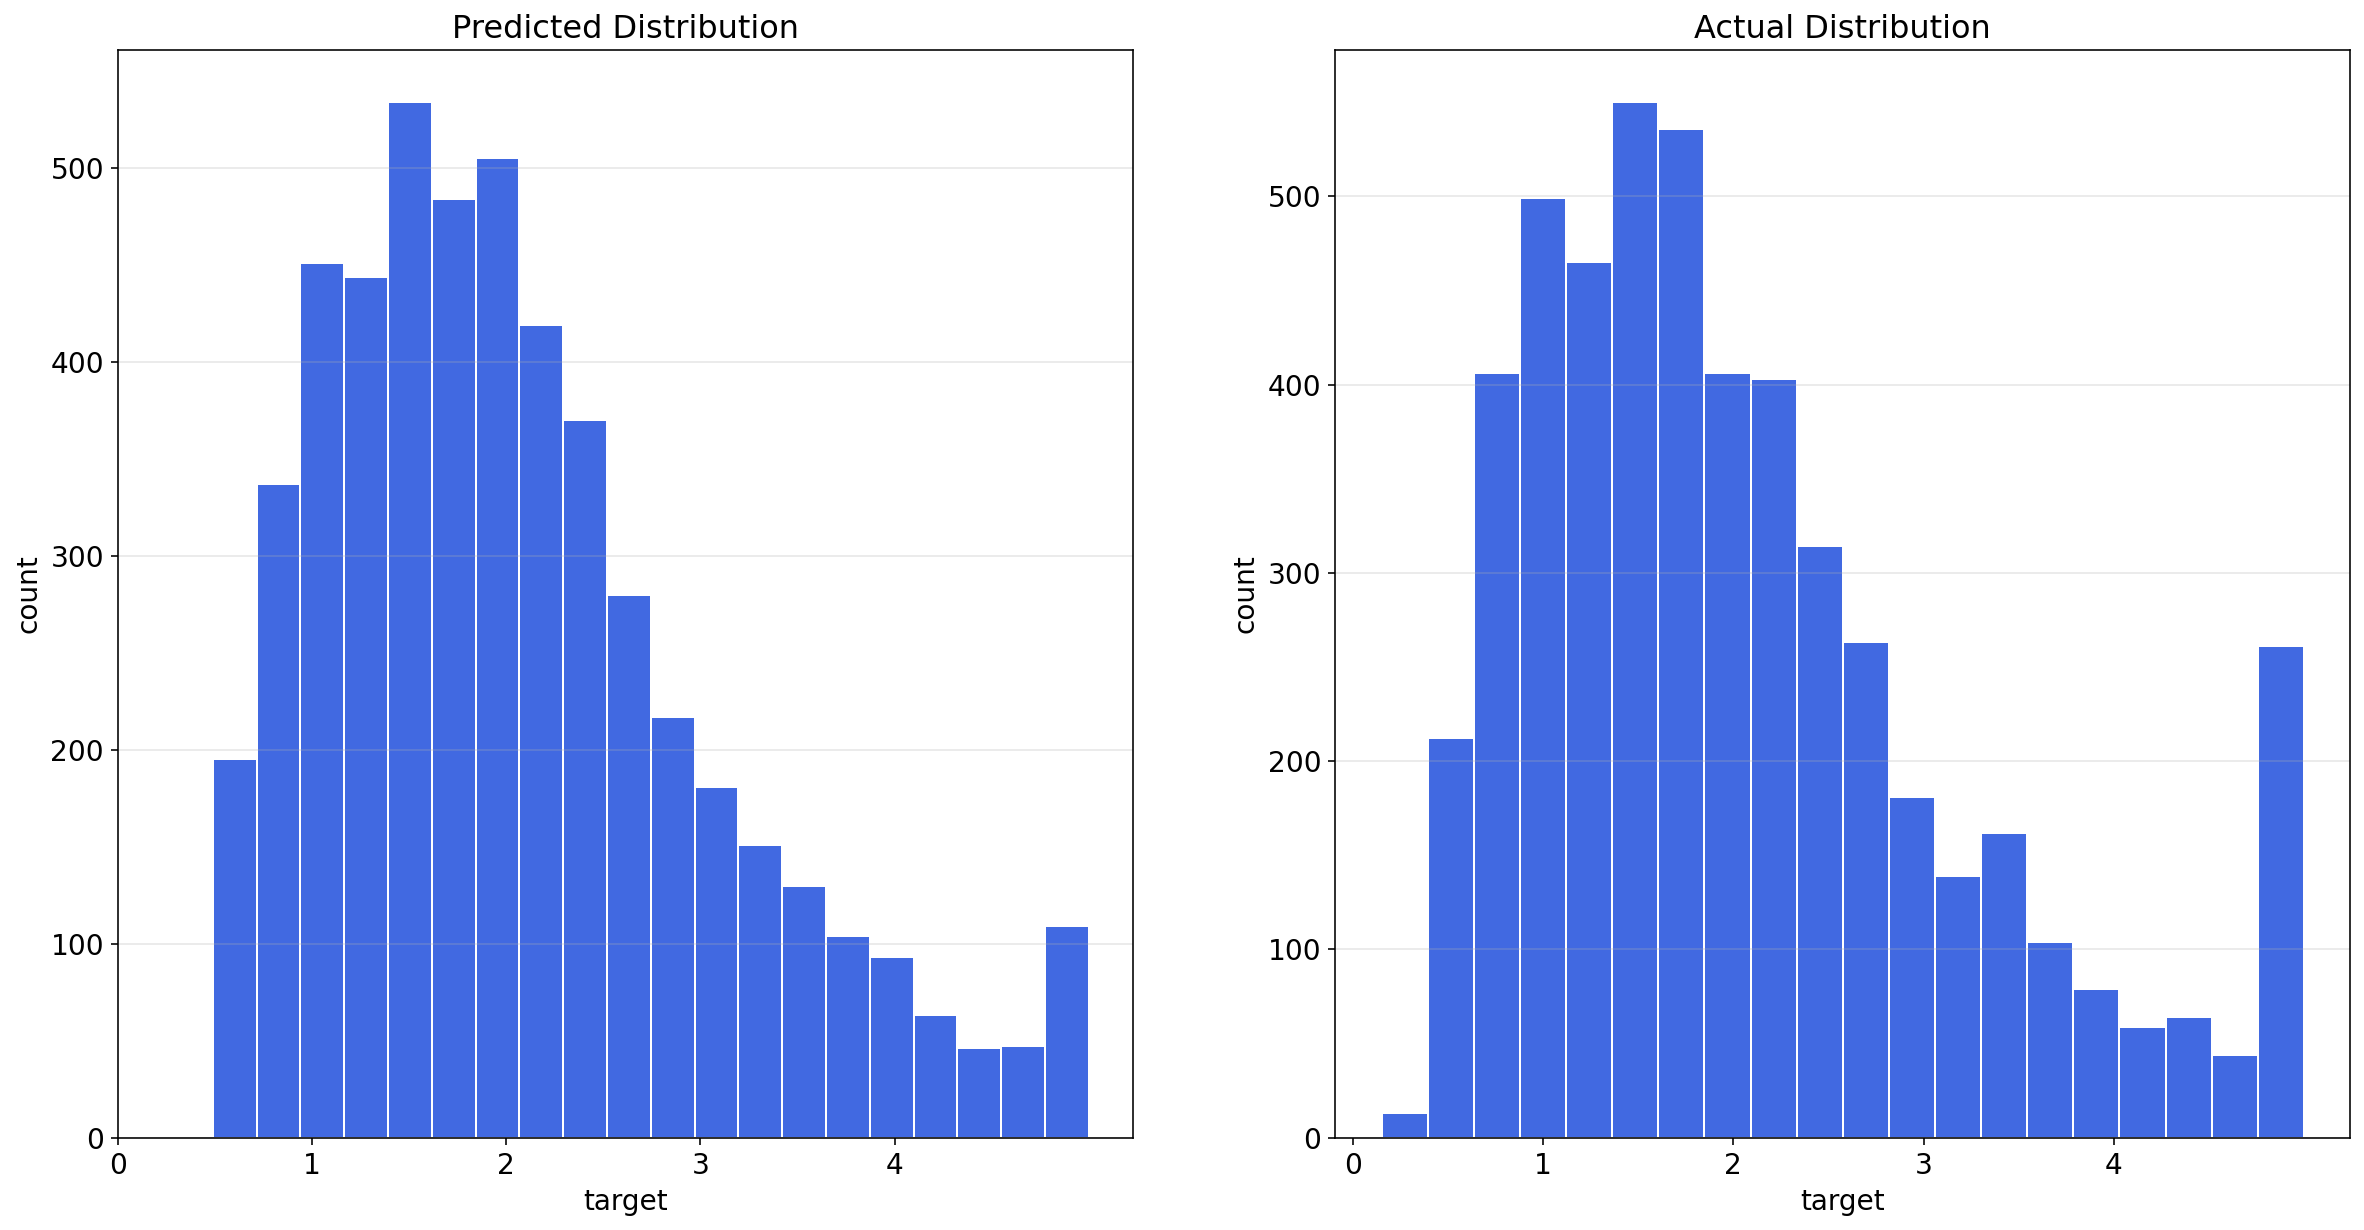

In [10]:
PlotPredictedVSActual(convert_target_to_array(predictions), convert_target_to_array(y_test))

The model can predict the house values between 0.5 and 4.5, but is not able to predict the points below 0.5 and house values above 4.5 which are less-frequent values of the distribution.

### Feature importances plot

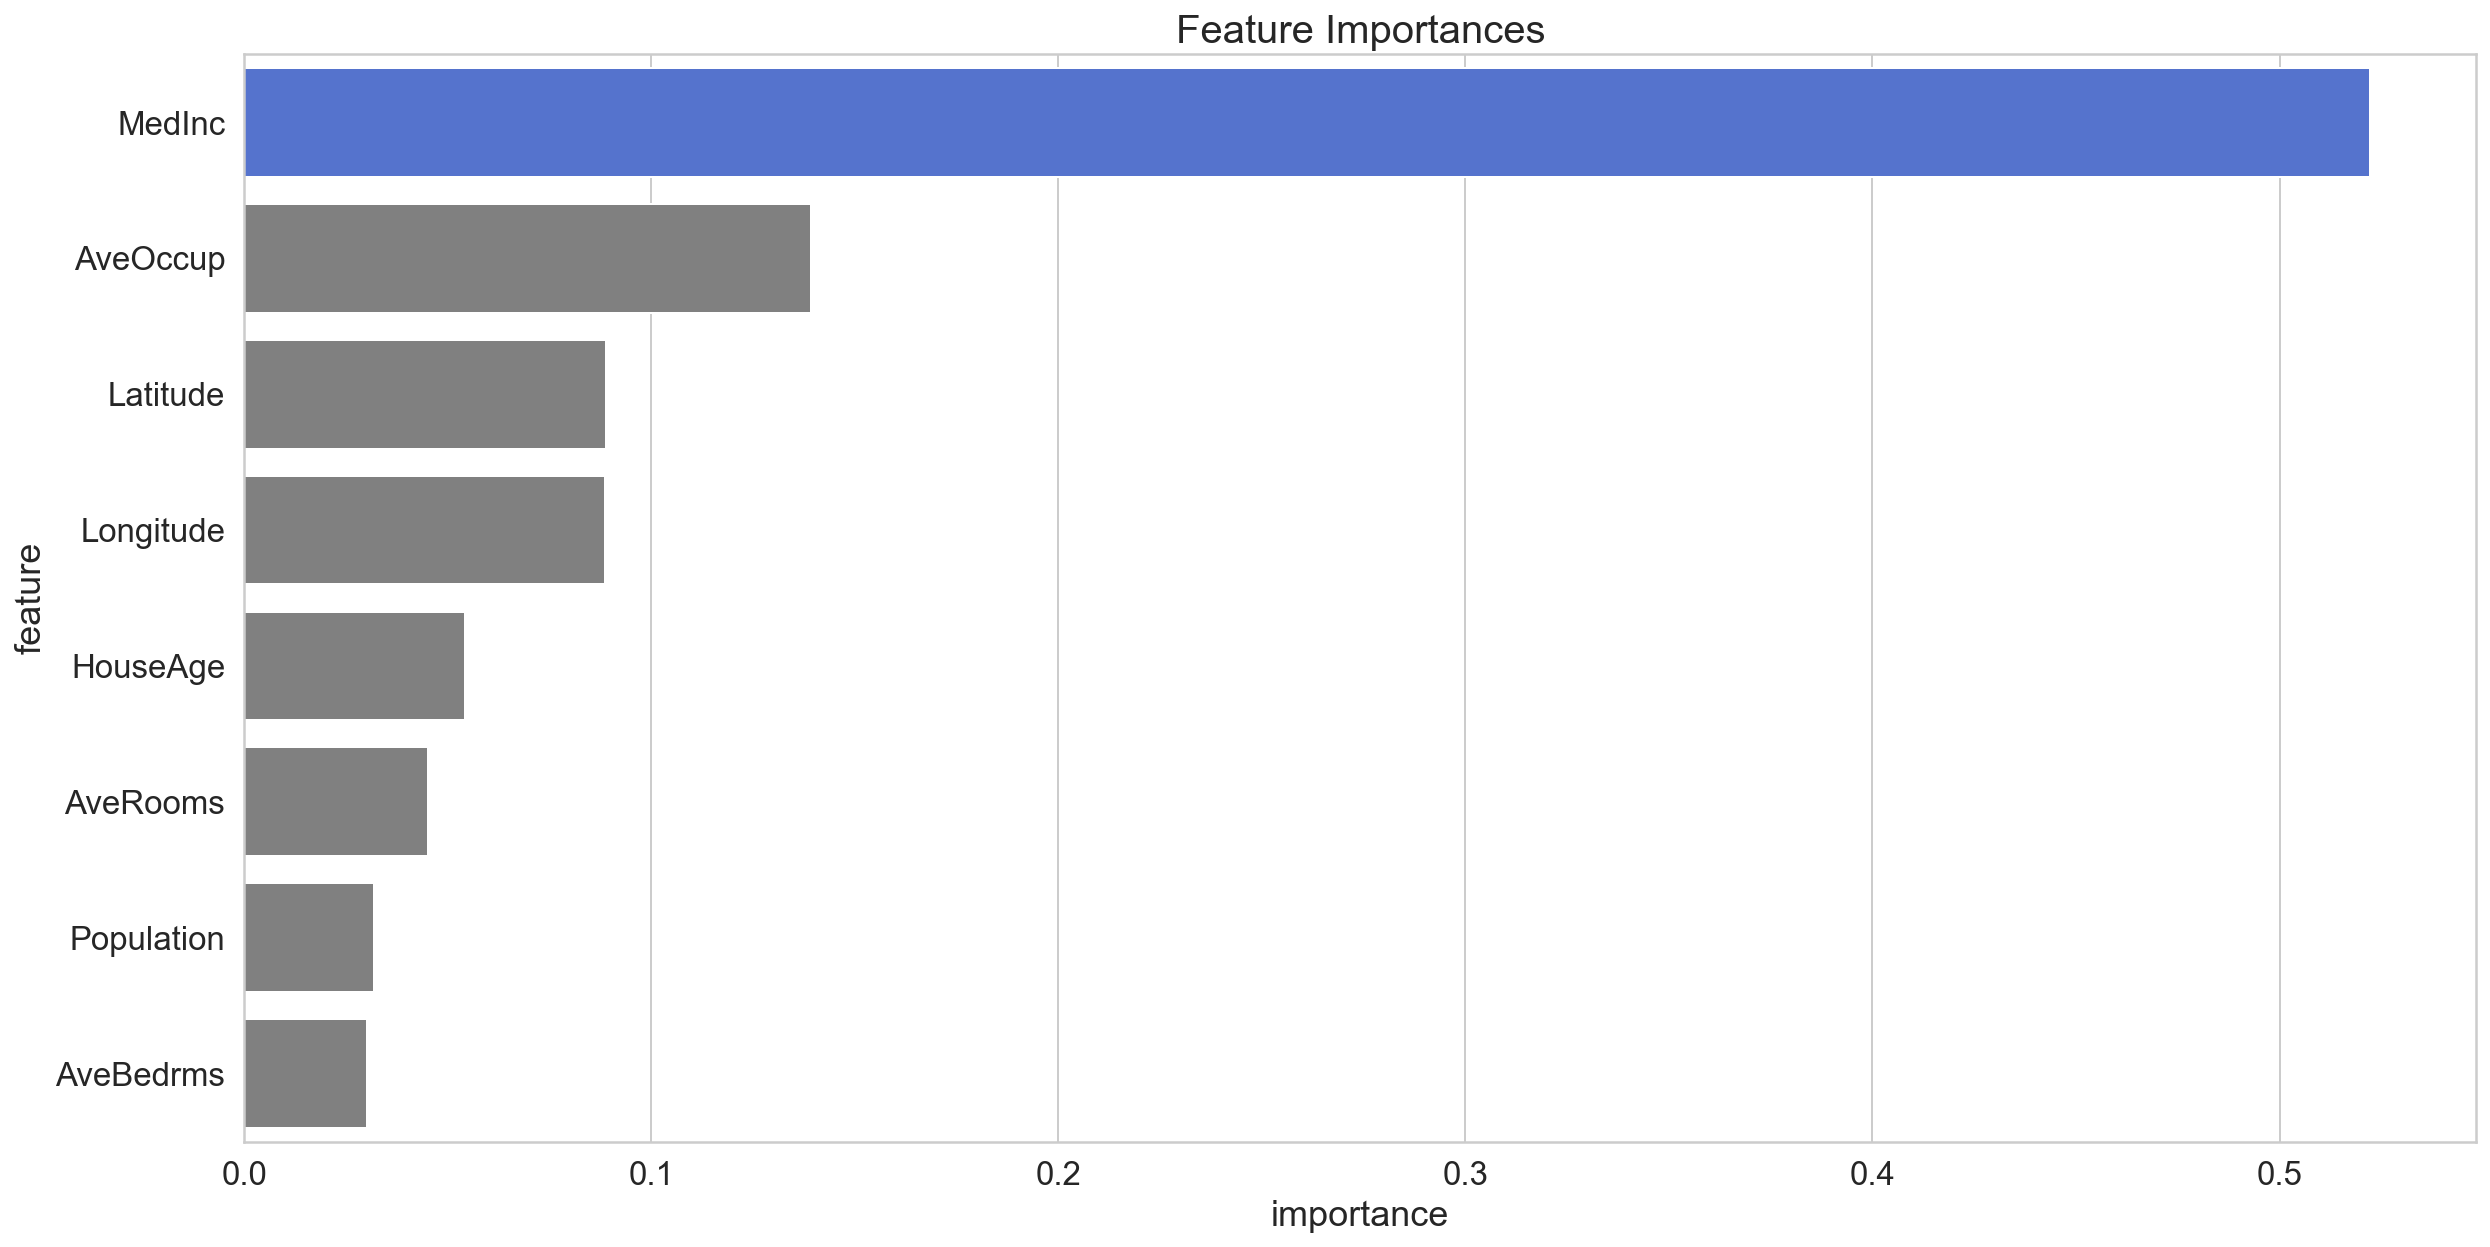

In [11]:
PlotFeatureImportances(random_forest_model, X_train.columns)

According to the model, the strongest predictor is **income**. The following most important features for predicting the value of a house are: **average house occupancy**, **latitude**, **longitude**.

### Permutation importances with ELI5



In [12]:
def ShowPermutationImportance(model, X_train, y_train):
    
    perm = (PermutationImportance(model, random_state=42)
            .fit(X_train, y_train))
    
    return eli5.show_weights(perm, 
                             feature_names = X_train.columns.tolist())

In [13]:
ShowPermutationImportance(random_forest_model, X_train, y_train)

Weight,Feature
0.8879 ± 0.0147,MedInc
0.4811 ± 0.0125,Latitude
0.3889 ± 0.0049,Longitude
0.3011 ± 0.0134,AveOccup
0.1199 ± 0.0043,HouseAge
0.0709 ± 0.0014,AveRooms
0.0373 ± 0.0005,AveBedrms
0.0348 ± 0.0007,Population


### Individual prediction explanations with SHAP

In [14]:
def IdentifyWrongAndRightPrediction(test_dataset, 
                                    predictions, 
                                    actuals, 
                                    individual_prediction):
    
    residuals = abs(predictions - convert_target_to_array(actuals))
    
    wrongest = (convert_features_to_array(test_dataset)
                [np.argmax(residuals), :])
    
    rightest = (convert_features_to_array(test_dataset)
                [np.argmin(residuals), :])
    
    test_dataset_output = test_dataset.reset_index(drop=True)
    
    test_dataset_output.loc[:,'predictions'] = np.round(predictions,2)
    
    
    if individual_prediction == "wrongest":
        return test_dataset_output.loc[np.argmax(residuals)]
    
    if individual_prediction == "rightest":
        return test_dataset_output.loc[np.argmin(residuals)]
        


In [15]:
def CreateWrongAndRightPredicitonDataFrame(test_dataset, predictions, actuals):
    
    test_dataset_test_with_wrongest_rightest = pd.concat(
        [pd.DataFrame(
            IdentifyWrongAndRightPrediction(
                test_dataset, 
                predictions, 
                actuals, 
                "wrongest")).T,
         
         pd.DataFrame(
             IdentifyWrongAndRightPrediction(
                 test_dataset, 
                 predictions, 
                 actuals, 
                 "rightest")).T])
    
    return test_dataset_test_with_wrongest_rightest

In [16]:
X_test_with_wrongest_rightest = CreateWrongAndRightPredicitonDataFrame(X_test, predictions, y_test)

In [17]:
X_test_with_wrongest_rightest

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,predictions
4479,2.6607,52.0,3.123134,1.113184,1202.0,1.495025,37.79,-122.42,4.51
198,11.2979,24.0,8.321970,1.013258,1443.0,2.732955,34.13,-118.49,5.00


In [18]:
# function to plot rightest and wrongest predciton with shap
shap.initjs()

def PlotShap(j, model, df_with_wrong_and_right_prediction):
    
    explainerModel = shap.TreeExplainer(model)
    
    shap_values_Model = explainerModel.shap_values(df_with_wrong_and_right_prediction)
    
    p = shap.force_plot(explainerModel.expected_value, 
                        shap_values_Model[j], 
                        df_with_wrong_and_right_prediction.iloc[[j]])
    return(p)

#### Wrongest Prediction

In [19]:
shap.initjs()
PlotShap(0, 
         random_forest_model, 
         X_test_with_wrongest_rightest)

#### Truest Prediction

In [20]:
shap.initjs()
PlotShap(1, 
         random_forest_model, 
         X_test_with_wrongest_rightest)